In [ ]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dirve_dir_data = "/content/drive/My Drive/MIE363_CaseStudy"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df_prod = pd.read_excel(dirve_dir_data + "/Prod3.xlsx", sheet_name= "all")   

In [ ]:
df_prod.dtypes

Unnamed: 0                         int64
Date                      datetime64[ns]
Product_Name                      object
Category_Name                     object
ActualShipmentInCases              int64
PricePerCase                       int64
Retail_POS_Sales_Units           float64
Retail_POS_Sales_Cases           float64
Retail_Inventory                 float64
AveragePrice                     float64
Week_Number                        int64
Week_Index                         int64
dtype: object

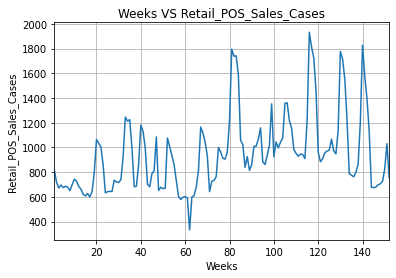

In [ ]:
plt.title('Weeks VS Retail_POS_Sales_Cases')
plt.ylabel('Retail_POS_Sales_Cases')
plt.xlabel('Weeks')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot( df_prod['Week_Index'], df_prod['Retail_POS_Sales_Cases'])

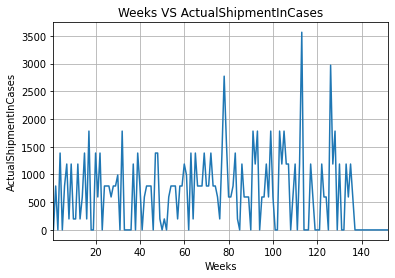

In [ ]:
plt.title('Weeks VS ActualShipmentInCases')
plt.ylabel('ActualShipmentInCases')
plt.xlabel('Weeks')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot( df_prod['Week_Index'], df_prod['ActualShipmentInCases'])

##Split

In [ ]:
rawdata = df_prod['Retail_POS_Sales_Cases']
train_data = rawdata
# test_data_size = 30
# train_data = rawdata[:-test_data_size]
# test_data = rawdata[-test_data_size:]
print(rawdata)

0       815.770
1       718.210
2       671.730
3       695.595
4       675.160
         ...   
147     705.260
148     725.970
149     825.765
150    1030.510
151     756.240
Name: Retail_POS_Sales_Cases, Length: 152, dtype: float64


## Data Processing

In [ ]:
np.random.seed(1000)
clean_signal = rawdata
mus = [2,5,10]
sigmas = [10,0.2,15]
new_data = []
for mu in mus:
  for sigma in sigmas:
    noise = np.random.normal(mu, sigma, len(clean_signal))
    signal = clean_signal + noise
    print(set(clean_signal) == set(signal))
    new_data.append(signal)


False
False
False
False
False
False
False
False
False


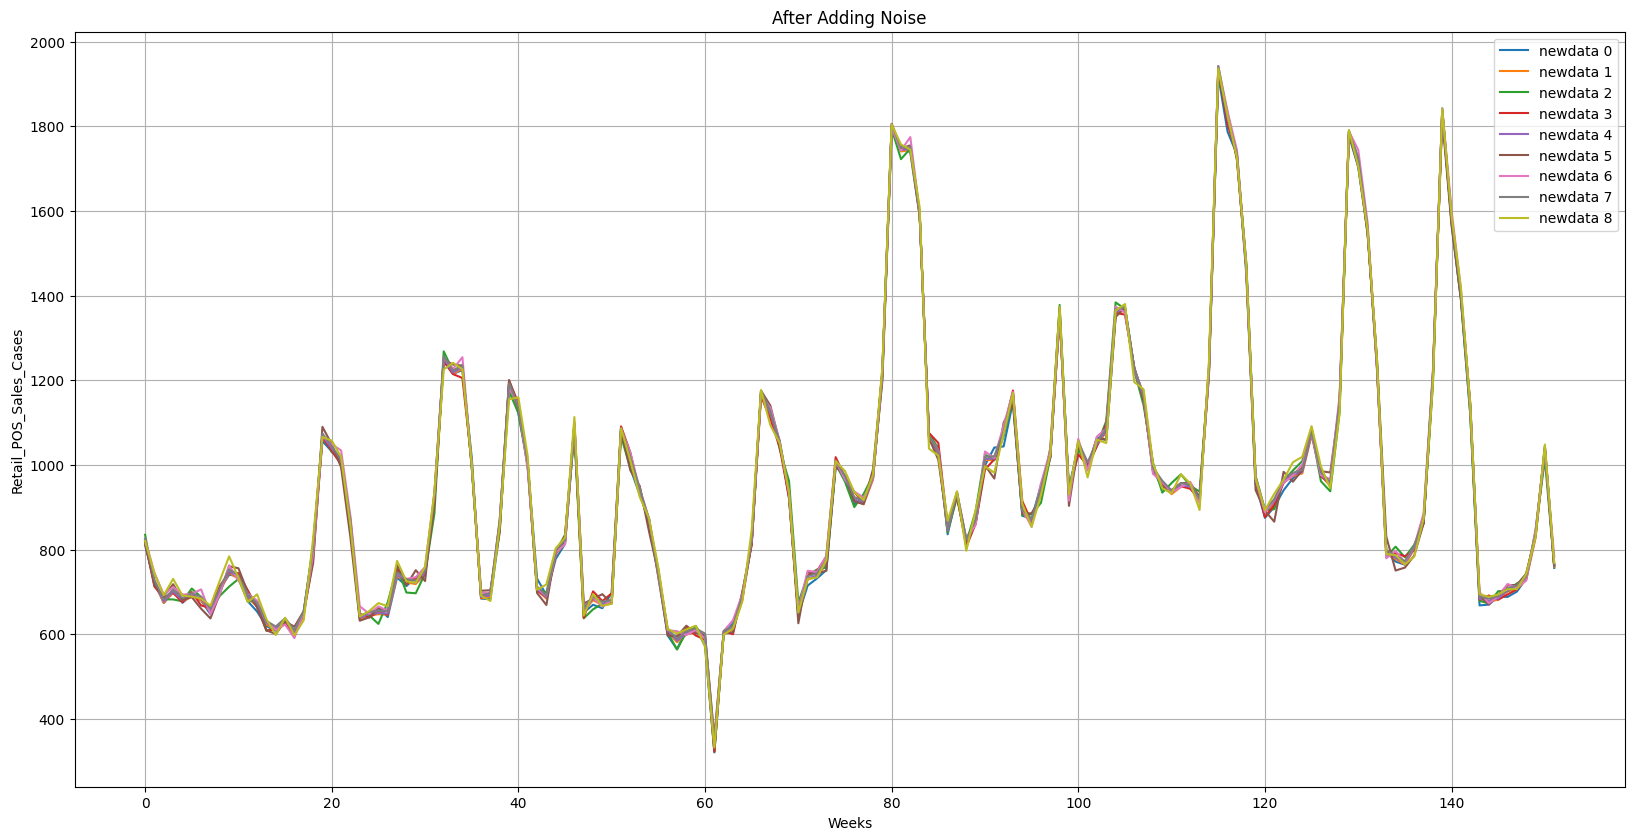

In [ ]:
y = new_data
fig,ax = plt.subplots(figsize=(20,10), dpi=100)
# ax.scatter(z1_sol, z2_sol,c = 'r', s = 10)
for i in range(len(y)):
    ax.plot(y[i],label = 'newdata %s'%i)
plt.title('After Adding Noise')
plt.ylabel('Retail_POS_Sales_Cases')
plt.xlabel('Weeks')
plt.grid(True)
plt.legend(loc='best')
plt.show()

##Normolize data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.values.reshape(-1, 1))

In [ ]:
data = []
normolized_data = []
for i in range(len(new_data)):
  train_data_arg1 = new_data[i]
  scaler = MinMaxScaler(feature_range=(-1, 1))
  train_data_arg1_normalized = scaler.fit_transform(train_data_arg1.values.reshape(-1, 1))
  data.extend(train_data_arg1)
  normolized_data.extend(train_data_arg1_normalized)
data.extend(rawdata)
normolized_data.extend(train_data_normalized)

NameError: ignored

In [ ]:
# to tensor 
data_normalized_tensor = torch.FloatTensor(normolized_data).view(-1)
data_tensor = torch.FloatTensor(data).view(-1)


In [ ]:
print(len(data_tensor))

1520


## Input sequences

In [ ]:
#generate input to feed into model as well as label 
def generate_input_sequences(input_data, tw, label_len):
    input_sequences = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+label_len]
        input_sequences.append((train_seq ,train_label))
    return input_sequences

In [ ]:
def get_train_val(data_tensor, train_window , label_len):
  total_seq = generate_input_sequences(data_tensor, train_window, label_len)
  actual_input = []
  for item in total_seq:
    seq, labels = item
    if len(labels) == label_len :
      actual_input.append((seq, labels))
  print(len(actual_input), len(total_seq))
  import random
  random.seed(1000)
  random.shuffle(actual_input)
  split = int(len(actual_input) * 0.8)
  train_input_seq = actual_input[:split]
  val_input_seq = actual_input[split:]
  print(len(train_input_seq))
  print(len(val_input_seq))
  return train_input_seq, val_input_seq

##Model:
input_size=1, each week have only 1 value

hidden_layer_size=100, 

output_size=4, predicitng number of sales in 4 weeks

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=4):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:

class LSTM_medium(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=4):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
class LSTM_large(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=200, output_size=4):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [ ]:
class ANN26(nn.Module):
    def __init__(self):
        super(ANN26, self).__init__()
        self.fc1 = nn.Linear(26, 15)
        self.fc2 = nn.Linear(15, 10)
        self.fc3 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1,26)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x.squeeze()

In [ ]:
def get_loss(model, train_input):
  error = 0
  for seq, labels in train_input:
    model_preds = model(seq)
    # print(model_preds)
    for i in range(len(model_preds)):
      model_pred = float(model_preds[i])
      truth = float(labels[i])
      error += abs(model_pred - truth)
  total_mad = error / ( len(train_input) * 4 )
  return total_mad 


In [ ]:
dirve_dir_model = "/content/drive/My Drive/MIE363_CaseStudy/LSTM/"
def train(model, train_input, val_input, learning_rate =0.001, num_epochs=30, name="rnn"):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    epoches, train_loss, val_loss = [], [], []
    for i in range(num_epochs):
      for seq, labels in train_input:
        optimizer.zero_grad()
        # print("blablab")
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)
        # print(y_pred)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
      train_loss.append(get_loss(model, train_input))
      val_loss.append(get_loss(model, val_input))
      epoches.append(i)
      if i % 5 == 0:
        model_path = dirve_dir_model + "Prod3_Epoch" + str(i) + name 
        torch.save(model.state_dict(), model_path)
        print("train_mad: ", i, " ", train_loss[-1])
      elif num_epochs - i < 3:
        model_path = dirve_dir_model + "Prod3_Epoch" + str(i) + name 
        torch.save(model.state_dict(), model_path)
        print("train_mad: ", i, " ", train_loss[-1])

       
    # plotting
    plt.title("Training Curve")
    plt.plot(epoches, train_loss, label="Train")
    plt.plot(epoches, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MAD")
    plt.legend(loc='best')
    plt.show()




In [ ]:
dirve_dir_model = "/content/drive/My Drive/MIE363_CaseStudy/LSTM/"
def trainANN(model, train_input, val_input, learning_rate =0.001, num_epochs=30, name="ann" ):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    epoches, train_loss, val_loss = [], [], []
    for i in range(num_epochs):
      for seq, labels in train_input:
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
      train_loss.append(get_loss(model, train_input))
      val_loss.append(get_loss(model, val_input))
      epoches.append(i)
      if i % 5 == 0:
        model_path = dirve_dir_model + "Prod3_Epoch" + str(i) + name 
        torch.save(model.state_dict(), model_path)
        print("train_mad: ", i, " ", train_loss[-1])
      elif num_epochs - i < 3:
        model_path = dirve_dir_model + "Prod3_Epoch" + str(i) + name 
        torch.save(model.state_dict(), model_path)
        print("train_mad: ", i, " ", train_loss[-1])
       
    # plotting
    plt.title("Training Curve")
    plt.plot(epoches, train_loss, label="Train")
    plt.plot(epoches, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("MAD")
    plt.legend(loc='best')
    plt.show()


## RNN

input = 26 

In [ ]:
train_input_seq, val_input_seq = get_train_val(data_tensor, 26 , 4)

1491 1494
1192
299


train_mad:  0   898.5781233550719
train_mad:  5   590.1787930174962
train_mad:  10   324.64729931210513
train_mad:  15   237.71429218061817
train_mad:  18   232.10041322644125
train_mad:  19   230.92853702314747


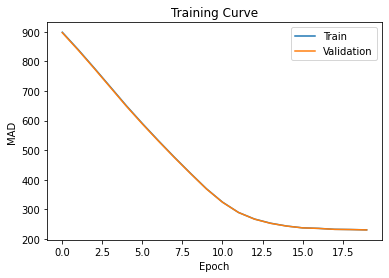

NameError: ignored

In [ ]:
#training
model_lstm = LSTM()
train(model_lstm, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 20)

train_mad:  0   813.8610095177721
train_mad:  5   266.53852821196483
train_mad:  10   230.3469425175814
train_mad:  15   232.25944385912595
train_mad:  18   232.4034750765602
train_mad:  19   232.41835475127968


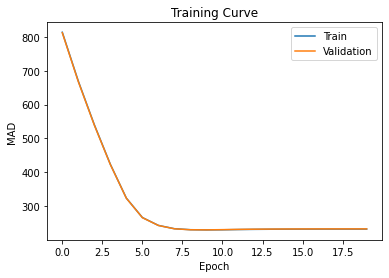

In [ ]:
model_lstm_med = LSTM_medium()
train(model_lstm_med, train_input_seq, val_input_seq, learning_rate =0.005, num_epochs= 20, name = "medium")

train_mad:  0   588.2864622205695
train_mad:  5   567.6176607912819
train_mad:  10   563.7274266633411
train_mad:  15   559.0627659663257
train_mad:  20   555.2829919341426
train_mad:  25   554.2493543240848
train_mad:  28   553.9875495513813
train_mad:  29   555.0051359906292


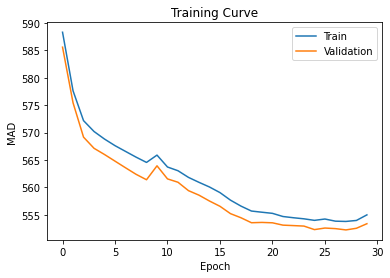

In [ ]:
model_ann = ANN26()
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 30, name = "ann26")

normolized data

1491 1494
1192
299
train_mad:  0   0.37116549263606774
train_mad:  5   0.36286720865049477
train_mad:  10   0.36300409204769624
train_mad:  15   0.36146870502297374
train_mad:  20   0.3582728634387941
train_mad:  25   0.354070954995485
train_mad:  28   0.3525686747881576
train_mad:  29   0.35153364382996805


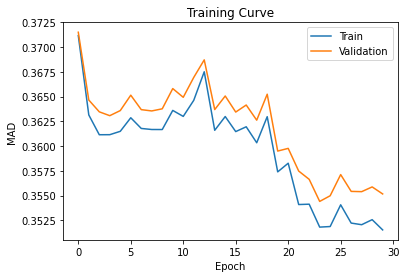

In [ ]:
train_norminput_seq, val_norminput_seq = get_train_val(data_normalized_tensor, 26 , 4)
model_ann = ANN26()
trainANN(model_ann, train_norminput_seq, val_norminput_seq, learning_rate =0.005, num_epochs= 30, name = "ann26norm")

train_mad:  0   0.21162345074238043
train_mad:  5   0.11772365490512111
train_mad:  10   0.08224825168754067
train_mad:  13   0.07688802437333657
train_mad:  14   0.07440080803853134


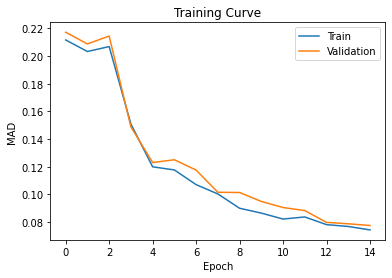

In [ ]:
model_lstm_large = LSTM()
train(model_lstm_large, train_norminput_seq, val_norminput_seq, learning_rate =0.001, num_epochs= 15, name = "26norm")

input = 52

In [ ]:
class ANN52(nn.Module):
    def __init__(self):
        super(ANN52, self).__init__()
        self.fc1 = nn.Linear(52, 30)
        self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1,52)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x.squeeze()

In [ ]:
train_input_seq, val_input_seq = get_train_val(data_tensor, 52 , 4)

1465 1468
1172
293


train_mad:  0   585.9614049045706
train_mad:  5   578.1899907369256
train_mad:  10   400.15908028404056
train_mad:  15   396.0690726257428
train_mad:  20   394.6242283635579
train_mad:  25   393.8342041106761
train_mad:  30   393.2956113587467
train_mad:  35   392.9060412462254
train_mad:  40   392.6020010274425
train_mad:  45   392.3611601285967
train_mad:  50   392.1708446606841
train_mad:  55   392.00952880130285
train_mad:  60   391.8684127989889
train_mad:  63   391.79138249341946
train_mad:  64   391.76681210644824


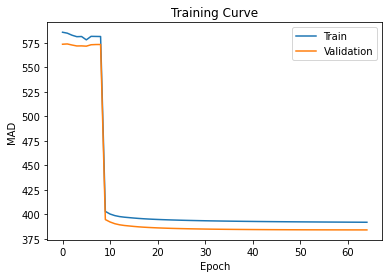

train_mad:  0   599.2261448557466
train_mad:  5   569.7121252769497
train_mad:  10   553.2848101475947
train_mad:  15   535.5662733670388
train_mad:  20   538.3119763644482
train_mad:  25   534.8415002855425
train_mad:  30   528.9041152277091
train_mad:  35   525.0843883227976
train_mad:  40   518.7446642214935
train_mad:  45   512.8414036356955
train_mad:  50   506.9109902756206
train_mad:  55   500.9998533359567
train_mad:  60   499.8348792079366
train_mad:  63   500.4608423213503
train_mad:  64   499.26336749340487


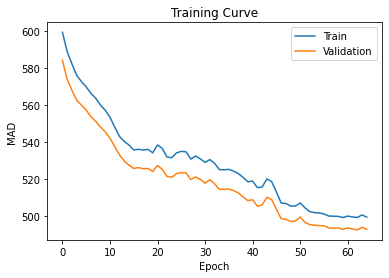

train_mad:  0   890.9734370879346
train_mad:  5   559.1585785862529
train_mad:  10   297.13621167518176
train_mad:  15   235.67692298368382
train_mad:  18   232.3895707179255
train_mad:  19   232.0757963486499


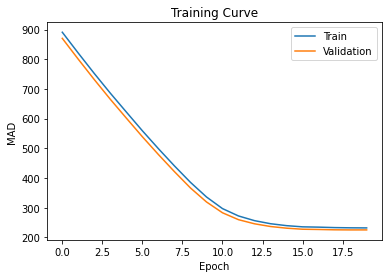

train_mad:  0   805.3222043554938
train_mad:  5   259.0627249043956
train_mad:  10   233.03369883384315
train_mad:  15   232.77688087619612
train_mad:  18   232.30996613616423
train_mad:  19   233.15813533926172


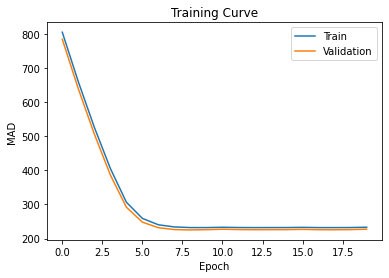

In [ ]:
model_ann = ANN52()
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.005, num_epochs= 65, name = "ann520.05")
model_ann = ANN52()
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 65, name = "ann52")
model_lstm = LSTM()
train(model_lstm, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 20, name = "reg52")
model_lstm_large = LSTM_large()
train(model_lstm_large, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 20, name = "large52")

1465 1468
1172
293
train_mad:  0   0.36699794569429117
train_mad:  5   0.3606017756112881
train_mad:  10   0.3586867146344517
train_mad:  15   0.34926342066838195
train_mad:  20   0.3498783637446448
train_mad:  25   0.34874489560270655
train_mad:  30   0.3517399826941051
train_mad:  35   0.3480044217169499
train_mad:  40   0.3488894322637098
train_mad:  45   0.3468901238545214
train_mad:  50   0.3466481727371086
train_mad:  55   0.346709244214939
train_mad:  58   0.3465452543724797
train_mad:  59   0.346679486928196


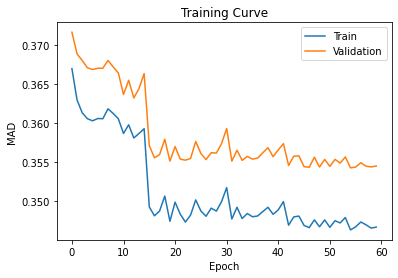

train_mad:  0   0.23326376253418807
train_mad:  5   0.2296256879944787
train_mad:  10   0.07274471493106123
train_mad:  15   0.04638183834786633
train_mad:  18   0.041326646770627966
train_mad:  19   0.030721405056267883


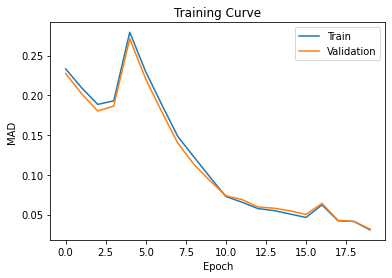

train_mad:  0   0.22338815696062
train_mad:  5   0.10655502077839107
train_mad:  10   0.08811411661634387
train_mad:  15   0.041596410193954554
train_mad:  18   0.037754381322014856
train_mad:  19   0.04370164602757817


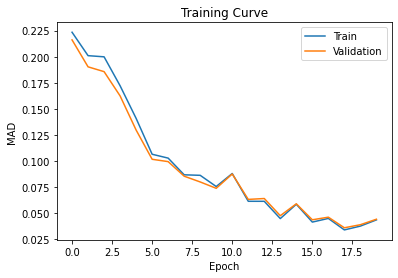

In [ ]:
train_input_seq, val_input_seq = get_train_val(data_normalized_tensor, 52 , 4)
trainANN(model_ann, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 60, name = "ann_norm52")
model_lstm = LSTM()
train(model_lstm, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 20, name = "reg_norm52")
model_lstm_large = LSTM_large()
train(model_lstm_large, train_input_seq, val_input_seq, learning_rate =0.001, num_epochs= 20, name = "large_norm52")

##Evaluate

In [ ]:
def testdata(bestmodel, timewindow, norm, filename, sheetname):
  prod2020 = pd.read_excel(dirve_dir_data + filename, sheet_name= sheetname)  
  test_label = prod2020['Retail_POS_Sales_Cases']
  test_label = test_label.to_list()
  test_input = rawdata[-timewindow:]
  test_input = test_input.to_list()
  if norm:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    test_input_norm = scaler.fit_transform(np.array(test_input).reshape(-1, 1))
    print("here")
    seq = torch.FloatTensor(test_input_norm)
    out = bestmodel(seq).detach().numpy()
    print("here")
    actual_predictions = scaler.inverse_transform(np.array(out).reshape(-1, 1))
  else:
    seq = torch.FloatTensor(test_input)
    out = bestmodel(seq)
    actual_predictions = out.detach().numpy()
  total_err = 0
  for i in range(len(test_label)):
    model_out = actual_predictions[i]
    label = test_label[i]
    error = abs(model_out - label)
    total_err += error
  mad = total_err / len(test_label)
  print(test_label)
  print(actual_predictions)
  print("mad: ", mad)

In [ ]:
#loading 
model_prod3_best = LSTM()
model_path = dirve_dir_model + "Prod3_Epoch19reg_norm52"
state = torch.load(model_path)
model_prod3_best.load_state_dict(state)
testdata(model_prod3_best, 52, True, "/Prod3.xlsx","prod3_2020")

here
here
[682.494999999999, 773.090000000001, 925.3450000000021, 844.430000000001]
[[ 998.7591]
 [1161.0846]
 [1183.9543]
 [1247.7797]]
mad:  [341.55444]


In [ ]:
#loading 
dirve_dir_model = "/content/drive/My Drive/MIE363_CaseStudy/LSTM/"
model_prod3_best = LSTM()
model_path = dirve_dir_model + "Prod3_Epoch15reg52"
state = torch.load(model_path)
model_prod3_best.load_state_dict(state)
testdata(model_prod3_best, 52, False, "/Prod3.xlsx","prod3_2020")

[682.494999999999, 773.090000000001, 925.3450000000021, 844.430000000001]
[861.3557  859.30164 862.45074 861.41156]
mad:  86.23704101562527


In [ ]:
#test_data
rawdata = df_prod['Retail_POS_Sales_Cases']
prod2020 = pd.read_excel(dirve_dir_data + "/Prod3.xlsx", sheet_name= "prod3_2020")  
test_new = prod2020['Retail_POS_Sales_Cases']
all_data = rawdata.append(test_new)
all_data = all_data.to_list()
test_input = all_data[-52:]
# test_input = test_input.to_list()
print(test_input)
# scaler = MinMaxScaler(feature_range=(-1, 1))
# test_input_norm = scaler.fit_transform(np.array(test_input).reshape(-1, 1))
seq = torch.FloatTensor(test_input)
out = model_prod3_best(seq).detach().numpy()
# actual_predictions = scaler.inverse_transform(np.array(out).reshape(-1, 1))
print(out)

[1356.975, 1361.975000000001, 1217.765000000001, 1155.69, 983.3249999999999, 952.580000000001, 929.349999999999, 946.5, 943.71, 910.08, 1217.154999999999, 1932.564999999999, 1814.01, 1724.139999999999, 1462.460000000001, 961.850000000001, 884.784999999999, 908.25, 957.6750000000001, 971.379999999999, 977.990000000001, 1068.21, 972.504999999999, 948.774999999999, 1141.284999999999, 1777.145000000001, 1715.805, 1550.859999999999, 1225.970000000001, 788.5700000000011, 775.29, 762.474999999999, 798.575000000001, 862.905, 1204.760000000001, 1827.615, 1574.109999999999, 1396.65, 1130.16, 678.354999999999, 674.585000000001, 679.5600000000001, 698.604999999999, 705.260000000001, 725.97, 825.765, 1030.509999999999, 756.24, 682.494999999999, 773.090000000001, 925.3450000000021, 844.430000000001]
[861.3557  859.30164 862.45074 861.41156]


In [ ]:
#loading 
model_prod3_best = LSTM_large()
model_path = dirve_dir_model + "Prod3_Epoch18large_norm52"
state = torch.load(model_path)
model_prod3_best.load_state_dict(state)
testdata(model_prod3_best, 52, True, "/Prod3.xlsx","prod3_2020")

here
here
[682.494999999999, 773.090000000001, 925.3450000000021, 844.430000000001]
[[ 968.6593]
 [1208.6757]
 [1380.047 ]
 [1190.7183]]
mad:  [380.68506]


In [ ]:
model_prod3_best = LSTM_large()
model_path = dirve_dir_model + "Prod3_Epoch18large52"
state = torch.load(model_path)
model_prod3_best.load_state_dict(state)
testdata(model_prod3_best, 52, False, "/Prod3.xlsx","prod3_2020")

[682.494999999999, 773.090000000001, 925.3450000000021, 844.430000000001]
[933.4417  931.71466 935.92914 935.5006 ]
mad:  127.80653015136642


In [ ]:
model_prod3_best = ANN26()
model_path = dirve_dir_model + "Prod3_Epoch20ann26norm"
state = torch.load(model_path)
model_prod3_best.load_state_dict(state)
testdata(model_prod3_best, 26, True, "/Prod3.xlsx","prod3_2020")

here
here
[682.494999999999, 773.090000000001, 925.3450000000021, 844.430000000001]
[[1251.1]
 [1251.1]
 [1251.1]
 [1251.1]]
mad:  [444.76]
